In [1]:
import numpy as np
import scipy.sparse as sp
import h5py
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Read the HP5 file
hfine = h5py.File('/content/drive/MyDrive/Colab Notebooks/vel3_cutout_les_fine.h5', 'r')
hcoarse = h5py.File('/content/drive/MyDrive/Colab Notebooks/vel3_cutout_les_coarse.h5', 'r')

In [3]:
a = len(list(hfine.keys())) - 3
b = len(list(hcoarse.keys())) - 3

In [4]:
def readsave(arg1,arg2):
  n1 = np.array(arg1[arg2][:])
  return n1

In [5]:
nfine = np.array([])
for i in range(a):
  n1 = readsave(hfine,list(hfine.keys())[i])
  n1 = n1.swapaxes(0,2)
  n1 = n1[:,:,0,0:2].reshape(n1.shape[0]**2,2)
  n1 = n1[:,np.newaxis,:]
  if i == 0:
    nfine = n1
  else:
    nfine = np.append(nfine,n1,axis=1)
    #print(n.shape)

In [6]:
ncoarse = np.array([])
for i in range(b):
  n1 = readsave(hcoarse,list(hcoarse.keys())[i])
  n1 = n1.swapaxes(0,2)
  n1 = n1[:,:,0,0:2].reshape(n1.shape[0]**2,2)
  n1 = n1[:,np.newaxis,:]
  if i == 0:
    ncoarse = n1
  else:
    ncoarse = np.append(ncoarse,n1,axis=1)
    #print(n.shape)

In [7]:
print(nfine.shape,ncoarse.shape)

(65536, 64, 2) (1024, 64, 2)


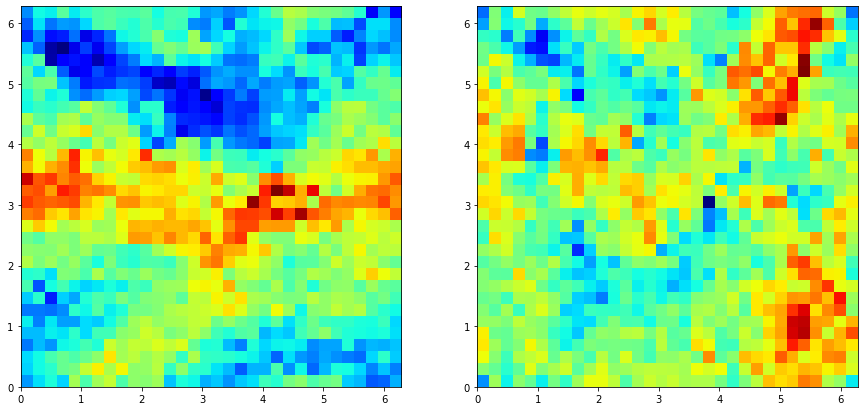

In [8]:
#u and v
%matplotlib inline
import matplotlib.pyplot as plt

a=32
fig = plt.figure(figsize = (15, 15))

count=0
for i in range(2):
  count+=1
  b = fig.add_subplot('12' + str(count))
  b.imshow(ncoarse[:,0,i-1].reshape(a,a),extent = [0, 6.28, 0, 6.28],cmap='jet')

In [9]:
#Calculate subgrid stresses from filtered fine matrix UiUj
def true_sgs(ncoarse,nfine):
  Uij = np.multiply(nfine[:,:,0],nfine[:,:,1])
  Uii = np.multiply(nfine[:,:,0],nfine[:,:,0])
  Ujj = np.multiply(nfine[:,:,1],nfine[:,:,1])
  tau_Uij = Uij[::64,:] - np.multiply(ncoarse[:,:,0],ncoarse[:,:,1])
  tau_Uii = Uii[::64,:] - np.multiply(ncoarse[:,:,0],ncoarse[:,:,0])
  tau_Ujj = Ujj[::64,:] - np.multiply(ncoarse[:,:,1],ncoarse[:,:,1])

  return tau_Uii,tau_Uij,tau_Ujj

tau_Uii,tau_Uij,tau_Ujj = true_sgs(ncoarse,nfine)

In [10]:
#Functions for Derivatives assuming periodic boundary conditions
def diff_operators(n,dx):
  n1 = n*n
  e0 = np.zeros((n1))
  e1 = np.ones((n1))
  e4 = np.zeros((n1))
  e5 = np.zeros((n1))
  e2 = np.ones((n1))
  e3 = np.zeros((n1))

  for i in range(n):
    e2[(n*(i+1))-1] = 0
    e3[(n*(i+1))-1] = 1

  e4[1:n1-1] = e2[0:n1-2]
  e4[0] = e2[n1-1]
  e5[1:n1-1] = e3[0:n1-2]
  e5[0] = e3[n1-1]

  data = np.array([e1,-e1,e1,-e1])
  diags = np.array([-(n1-n), -n, n, (n1-n)])
  spA = sp.spdiags(data,diags,n1,n1)

  data1 = np.array([e5,-e2,e0,e4,-e3])
  diags1 = np.array([-n+1,-1,0,1,n-1])
  spB = sp.spdiags(data1,diags1,n1,n1);

  A = spA.toarray()/(2*dx);
  B = spB.toarray()/(2*dx);

  return A,B

In [11]:
dx = 2*np.pi/32
A,B = diff_operators(32,dx)

In [12]:
#Computing derivative features
ux = np.zeros((ncoarse.shape[0],ncoarse.shape[1]))
vx = np.zeros((ncoarse.shape[0],ncoarse.shape[1]))
uy = np.zeros((ncoarse.shape[0],ncoarse.shape[1]))
vy = np.zeros((ncoarse.shape[0],ncoarse.shape[1]))
uxx = np.zeros((ncoarse.shape[0],ncoarse.shape[1]))
vxx = np.zeros((ncoarse.shape[0],ncoarse.shape[1]))
uyy = np.zeros((ncoarse.shape[0],ncoarse.shape[1]))
vyy = np.zeros((ncoarse.shape[0],ncoarse.shape[1]))

for i in range(ncoarse.shape[1]):
  ux[:,i] = A.dot(ncoarse[:,i,0])
  vx[:,i] = A.dot(ncoarse[:,i,1])
  uxx[:,i] = A.dot(A.dot(ncoarse[:,i,0]))
  vxx[:,i] = A.dot(A.dot(ncoarse[:,i,1]))
  uy[:,i] = B.dot(ncoarse[:,i,0])
  vy[:,i] = B.dot(ncoarse[:,i,1])
  uyy[:,i] = B.dot(B.dot(ncoarse[:,i,0]))
  vyy[:,i] = B.dot(B.dot(ncoarse[:,i,1]))

ux = ux[:,:,np.newaxis]
vx = vx[:,:,np.newaxis]
uxx = uxx[:,:,np.newaxis]
vxx = vxx[:,:,np.newaxis]
uy = uy[:,:,np.newaxis]
vy = vy[:,:,np.newaxis]
uyy = uyy[:,:,np.newaxis]
vyy = vyy[:,:,np.newaxis]

In [13]:
uxx.shape

(1024, 64, 1)

In [14]:
#Smagorinsky estimation of Tau (SG Stresses)
Cs = .1678

def smag_compute(input_coarse,input_fine):
  ux = input_coarse[:,:,2][:,:,np.newaxis]
  vx = input_coarse[:,:,3][:,:,np.newaxis]
  uy = input_coarse[:,:,4][:,:,np.newaxis]
  vy = input_coarse[:,:,5][:,:,np.newaxis]
  
  input_coarse = input_coarse[:,:,0:2]
  tau_Uii,tau_Uij,tau_Ujj = true_sgs(input_coarse,input_fine)
  
  Sii = ux
  Sjj = vy
  Sij = (uy + vx)/2
  tau_kk = (tau_Uii + tau_Ujj)/2

  tau_sii = -2*(Cs*dx**2)*np.multiply(np.sqrt(2*np.multiply(Sii,Sii)),Sii) + tau_kk[:,:,np.newaxis]
  tau_sij = -2*(Cs*dx**2)*np.multiply(np.sqrt(2*np.multiply(Sij,Sij)),Sij) + tau_kk[:,:,np.newaxis]
  tau_sjj = -2*(Cs*dx**2)*np.multiply(np.sqrt(2*np.multiply(Sjj,Sjj)),Sjj) + tau_kk[:,:,np.newaxis]

  op_smag = np.concatenate((tau_sii,tau_sij,tau_sjj),axis=0).reshape(ncoarse.shape[0]*3,input_coarse.shape[1])
  return op_smag

In [15]:
#Setup Input and Output features
input = ncoarse
input = np.append(input,ux,axis=2)
input = np.append(input,vx,axis=2)
input = np.append(input,uy,axis=2)
input = np.append(input,vy,axis=2)
input = np.append(input,uxx,axis=2)
input = np.append(input,vxx,axis=2)
input = np.append(input,uyy,axis=2)
input = np.append(input,vyy,axis=2)

output = tau_Uii[:,:,np.newaxis]
output = np.append(output,tau_Uij[:,:,np.newaxis],axis=2)
output = np.append(output,tau_Ujj[:,:,np.newaxis],axis=2)

print(input.shape,output.shape)
input = input.swapaxes(0,1)
output = output.swapaxes(0,1)
print(input.shape,output.shape)

(1024, 64, 10) (1024, 64, 3)
(64, 1024, 10) (64, 1024, 3)


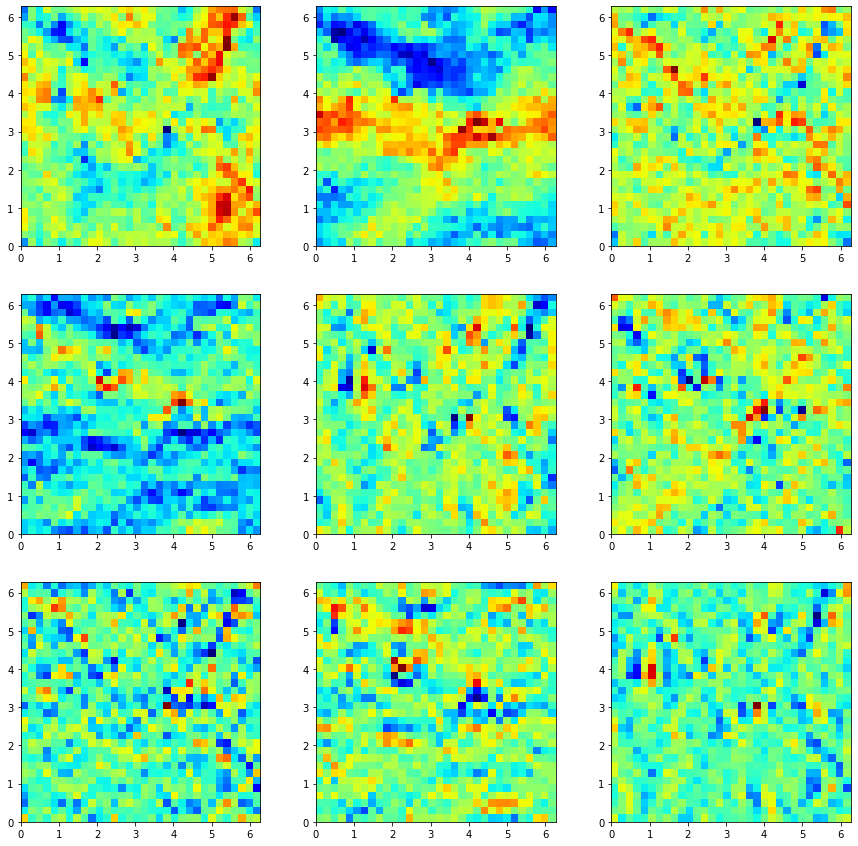

In [16]:
#All derivative
%matplotlib inline
import matplotlib.pyplot as plt

a=32
fig = plt.figure(figsize = (15, 15))

count=0
for i in range(9):
  count+=1
  b = fig.add_subplot('33' + str(count))
  b.imshow(input[0,:,i].reshape(a,a),extent = [0, 6.28, 0, 6.28],cmap='jet')

In [17]:
#Setup validation and demean all inputs
input = input.reshape(64,10240)
output = output.reshape(64,1024*3)

mean_ip = input.mean(axis=0,keepdims=True)
mean_op = output.mean(axis=0,keepdims=True)

nn_im = input - mean_ip
nn_om = output - mean_op

nn_im_test = nn_im[60:64,:]
nn_om_test = nn_om[60:64,:]
nn_fine_test = nfine[:,60:64,:]

nn_im = nn_im[:60,:]
nn_om = nn_om[:60,:]
from sklearn.model_selection import train_test_split

all_indices = list(range(nn_im.shape[0]))
train, dev = train_test_split(all_indices, test_size=0.2)

nn_ipm = nn_im[train,:]
nn_idm = nn_im[dev,:]
nn_opm = nn_om[train,:]
nn_odm = nn_om[dev,:]

nn_ipm_small = nn_ipm[:,:ncoarse.shape[0]*2]
nn_idm_small = nn_idm[:,:ncoarse.shape[0]*2]
nn_opm_small = nn_opm
nn_odm_small = nn_odm

nn_ipm_cnn = nn_ipm.reshape(nn_ipm.shape[0],32,32,10)
nn_idm_cnn = nn_idm.reshape(nn_idm.shape[0],32,32,10)
nn_opm_cnn = nn_opm.reshape(nn_opm.shape[0],32,32,3)
nn_odm_cnn = nn_odm.reshape(nn_odm.shape[0],32,32,3)

print(nn_ipm.shape, nn_opm.shape, nn_idm.shape, nn_odm.shape)
print(nn_ipm_small.shape, nn_opm_small.shape, nn_idm_small.shape, nn_odm_small.shape)
print(nn_ipm_cnn.shape, nn_opm_cnn.shape, nn_idm_cnn.shape, nn_odm_cnn.shape)
print(nn_im_test.shape,nn_om_test.shape)

(48, 10240) (48, 3072) (12, 10240) (12, 3072)
(48, 2048) (48, 3072) (12, 2048) (12, 3072)
(48, 32, 32, 10) (48, 32, 32, 3) (12, 32, 32, 10) (12, 32, 32, 3)
(4, 10240) (4, 3072)


In [18]:
#Train NN to model this one timestep
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras import optimizers
from keras.layers import Activation
from keras.layers import Dense, Conv2D, Flatten
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K

In [19]:
input.shape[1]

10240

In [20]:
# Build model
deep_approx = keras.models.Sequential()
deep_approx.add(layers.Dense(1000, input_dim=nn_ipm_small.shape[1], activation='sigmoid'))
deep_approx.add(layers.Dense(2000, activation='relu'))
deep_approx.add(layers.Dense(2000, activation='relu'))
deep_approx.add(layers.Dense(output.shape[1], activation='linear'))

# Compile model
deep_approx.compile(loss='mse', optimizer='adam')

# Fit!
History = deep_approx.fit(nn_ipm_small, nn_opm_small, epochs=500,
                          validation_data=(nn_idm_small, nn_odm_small),verbose=0)

In [21]:
# Build model
deep_approx1 = keras.models.Sequential()
deep_approx1.add(layers.Dense(10000, input_dim=input.shape[1], activation='sigmoid'))
deep_approx1.add(layers.Dense(5000, activation='relu'))
deep_approx1.add(layers.Dense(5000, activation='relu'))
deep_approx1.add(layers.Dense(output.shape[1], activation='linear'))

# Compile model
deep_approx1.compile(loss='mse', optimizer='adam')

# Fit!
History1 = deep_approx1.fit(nn_ipm, nn_opm, epochs=500,
                          validation_data=(nn_idm, nn_odm),verbose=0)

In [22]:
# Build model
deep_app_cnn = keras.models.Sequential()
deep_app_cnn.add(Conv2D(16,(3,3),activation='relu',padding='same',input_shape=(32,32,10)))
deep_app_cnn.add(Conv2D(8,(3,3),activation='relu',padding='same'))
deep_app_cnn.add(Conv2D(8,(3,3),activation='relu',padding='same'))
deep_app_cnn.add(Conv2D(8,(3,3),activation='relu',padding='same'))
deep_app_cnn.add(Conv2D(8,(3,3),activation='relu',padding='same'))
deep_app_cnn.add(Conv2D(16,(3,3),activation='relu',padding='same'))
deep_app_cnn.add(Conv2D(3,(3,3),activation='linear',padding='same'))

# Compile model
deep_app_cnn.compile(loss='mse', optimizer='adam')

# Fit!
History2 = deep_app_cnn.fit(nn_ipm_cnn, nn_opm_cnn, epochs=500,
                          validation_data=(nn_idm_cnn, nn_odm_cnn),verbose=0)

In [23]:
deep_approx.summary()
deep_approx1.summary()
deep_app_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, 1000)              2049000   
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 2000)              2002000   
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 2000)              4002000   
_________________________________________________________________
module_wrapper_3 (ModuleWrap (None, 3072)              6147072   
Total params: 14,200,072
Trainable params: 14,200,072
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_4 (ModuleWrap (None, 10000)             102410000 
______________________

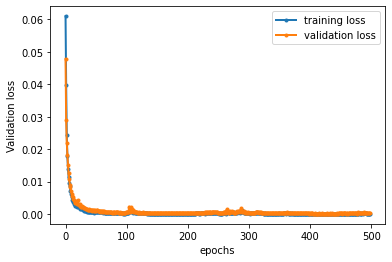

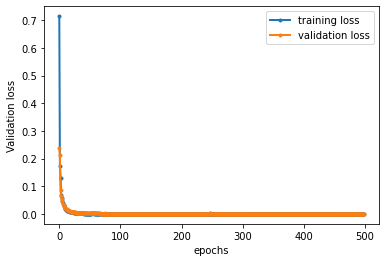

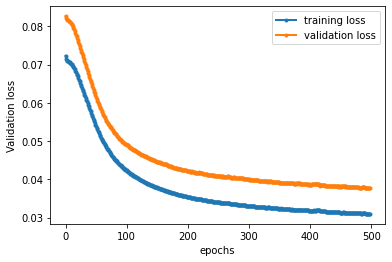

In [24]:
idx0 = 1
import matplotlib.pyplot as plt

plt.figure()
plt.plot(History.history['loss'][idx0:], '.-', lw=2)
plt.plot(History.history['val_loss'][idx0:], '.-', lw=2)
plt.xlabel('epochs')
plt.ylabel('Validation loss')
plt.legend(['training loss', 'validation loss'])
plt.show()

plt.figure()
plt.plot(History1.history['loss'][idx0:], '.-', lw=2)
plt.plot(History1.history['val_loss'][idx0:], '.-', lw=2)
plt.xlabel('epochs')
plt.ylabel('Validation loss')
plt.legend(['training loss', 'validation loss'])
plt.show()

plt.figure()
plt.plot(History2.history['loss'][idx0:], '.-', lw=2)
plt.plot(History2.history['val_loss'][idx0:], '.-', lw=2)
plt.xlabel('epochs')
plt.ylabel('Validation loss')
plt.legend(['training loss', 'validation loss'])
plt.show()

In [25]:
#Test all estimators
test_input = nn_im_test
test_fine = nn_fine_test
test_output = nn_om_test

test_pred_m1 = deep_approx.predict(test_input[:,:32*32*2])
test_pred_m2 = deep_approx1.predict(test_input)
test_pred_m3 = deep_app_cnn.predict(test_input.reshape(4,32,32,10))

test_coarse = (test_input + mean_ip).transpose().reshape(32*32,test_input.shape[0],10)
test_pred_smag = smag_compute(test_coarse,test_fine).transpose() - mean_op

In [26]:
test_pred_m3.shape

(4, 32, 32, 3)

In [27]:
#Reshape the stress vector predictions
test_pred_m1 = test_pred_m1.reshape(4,1024,3)
test_pred_m2 = test_pred_m2.reshape(4,1024,3)
test_pred_m3 = test_pred_m3.reshape(4,1024,3)
test_pred_smag = test_pred_smag.reshape(4,1024,3)
test_true = test_output.reshape(4,1024,3)

tau_11_m1 = test_pred_m1[:,:,0]
tau_11_m2 = test_pred_m2[:,:,0]
tau_11_m3 = test_pred_m3[:,:,0]
tau_11_smag = test_pred_smag[:,:,0]
tau_11_true = test_true[:,:,0]

tau_12_m1 = test_pred_m1[:,:,1]
tau_12_m2 = test_pred_m2[:,:,1]
tau_12_m3 = test_pred_m3[:,:,1]
tau_12_smag = test_pred_smag[:,:,1]
tau_12_true = test_true[:,:,1]


tau_22_m1 = test_pred_m1[:,:,2]
tau_22_m2 = test_pred_m2[:,:,2]
tau_22_m3 = test_pred_m3[:,:,2]
tau_22_smag = test_pred_smag[:,:,2]
tau_22_true = test_true[:,:,2]

print(tau_11_m1.shape,tau_11_m2.shape,tau_11_m3.shape,tau_11_smag.shape,tau_11_true.shape)
print(tau_12_m1.shape,tau_12_m2.shape,tau_12_m3.shape,tau_12_smag.shape,tau_12_true.shape)
print(tau_22_m1.shape,tau_22_m2.shape,tau_22_m3.shape,tau_22_smag.shape,tau_22_true.shape)

(4, 1024) (4, 1024) (4, 1024) (4, 1024) (4, 1024)
(4, 1024) (4, 1024) (4, 1024) (4, 1024) (4, 1024)
(4, 1024) (4, 1024) (4, 1024) (4, 1024) (4, 1024)


In [28]:
#MAE for various Taus
error_t11m1 = np.abs(tau_11_m1 - tau_11_true)
error_t11m2 = np.abs(tau_11_m2 - tau_11_true)
error_t11m3 = np.abs(tau_11_m3 - tau_11_true)
error_t11smag = np.abs(tau_11_smag - tau_11_true)

error_t12m1 = np.abs(tau_12_m1 - tau_12_true)
error_t12m2 = np.abs(tau_12_m2 - tau_12_true)
error_t12m3 = np.abs(tau_12_m3 - tau_12_true)
error_t12smag = np.abs(tau_12_smag - tau_12_true)

error_t22m1 = np.abs(tau_22_m1 - tau_22_true)
error_t22m2 = np.abs(tau_22_m2 - tau_22_true)
error_t22m3 = np.abs(tau_22_m3 - tau_22_true)
error_t22smag = np.abs(tau_22_smag - tau_22_true)

mean_t11m1 = np.mean(np.mean(error_t11m1,axis=1))
sd_t11m1 = np.std(np.mean(error_t11m1,axis=1))

mean_t11m2 = np.mean(np.mean(error_t11m2,axis=1))
sd_t11m2 = np.std(np.mean(error_t11m2,axis=1))

mean_t11m3 = np.mean(np.mean(error_t11m3,axis=1))
sd_t11m3 = np.std(np.mean(error_t11m3,axis=1))

mean_t11smag = np.mean(np.mean(error_t11smag,axis=1))
sd_t11smag = np.std(np.mean(error_t11smag,axis=1))

mean_t12m1 = np.mean(np.mean(error_t12m1,axis=1))
sd_t12m1 = np.std(np.mean(error_t12m1,axis=1))

mean_t12m2 = np.mean(np.mean(error_t12m2,axis=1))
sd_t12m2 = np.std(np.mean(error_t12m2,axis=1))

mean_t12m3 = np.mean(np.mean(error_t12m3,axis=1))
sd_t12m3 = np.std(np.mean(error_t12m3,axis=1))

mean_t12smag = np.mean(np.mean(error_t12smag,axis=1))
sd_t12smag = np.std(np.mean(error_t12smag,axis=1))

mean_t22m1 = np.mean(np.mean(error_t22m1,axis=1))
sd_t22m1 = np.std(np.mean(error_t22m2,axis=1))

mean_t22m2 = np.mean(np.mean(error_t22m2,axis=1))
sd_t22m2 = np.std(np.mean(error_t22m2,axis=1))

mean_t22m3 = np.mean(np.mean(error_t22m3,axis=1))
sd_t22m3 = np.std(np.mean(error_t22m3,axis=1))

mean_t22smag = np.mean(np.mean(error_t22smag,axis=1))
sd_t22smag = np.std(np.mean(error_t22smag,axis=1))

print(mean_t11m1,mean_t11m2,mean_t11m3,mean_t11smag,sd_t11m1,sd_t11m2,sd_t11m3,sd_t11smag)
print(mean_t12m1,mean_t12m2,mean_t12m3,mean_t12smag,sd_t12m1,sd_t12m2,sd_t12m3,sd_t12smag)
print(mean_t22m1,mean_t22m2,mean_t22m3,mean_t22smag,sd_t22m1,sd_t22m2,sd_t22m3,sd_t22smag)

0.060973357 0.059998155 0.23289631 9.02962872911642 0.01759095 0.01750671 0.017750079 13.554141738605583
0.059085257 0.057123937 0.20759249 8.976424635372162 0.017791314 0.017449817 0.0146372225 13.550149494481646
0.080135904 0.07902002 0.3103711 9.086998382968554 0.02416587 0.02416587 0.034803316 13.492391298993


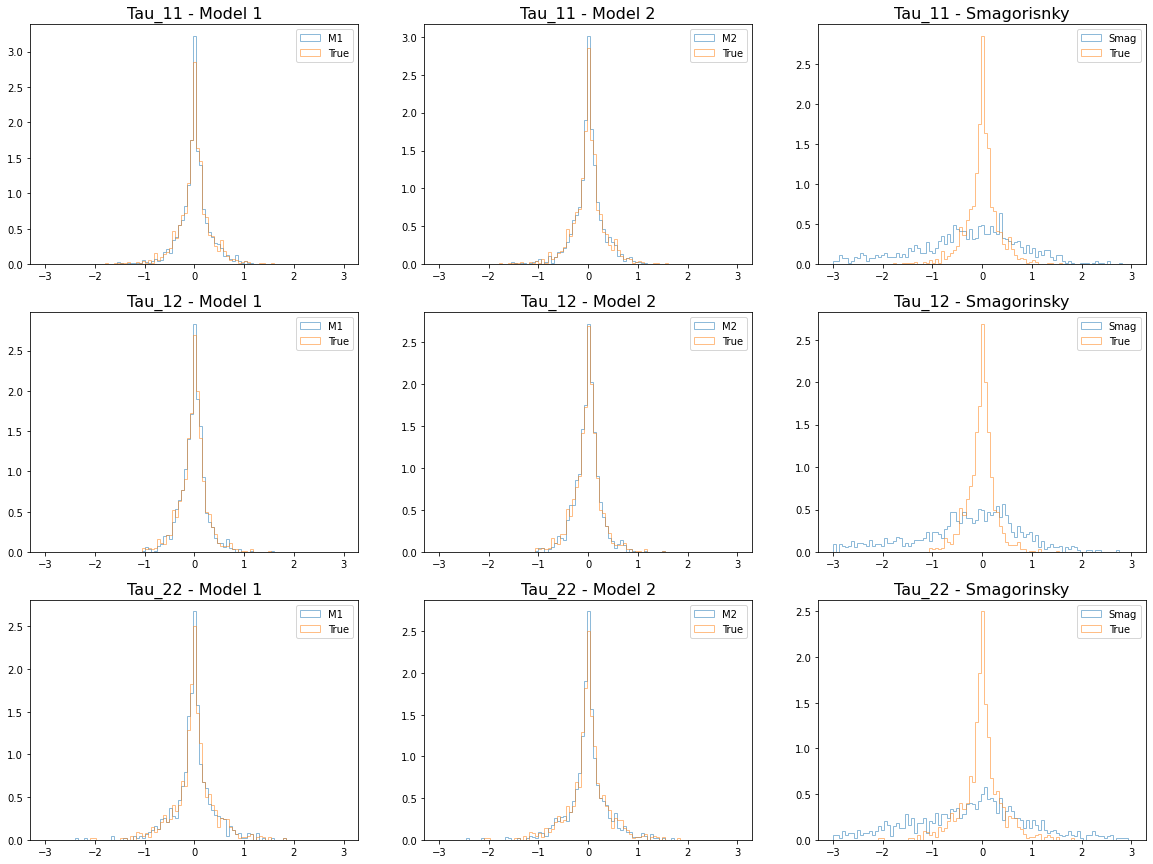

In [29]:
#Plot PDF
from matplotlib import pyplot

fig = pyplot.figure(figsize = (20, 15))

x = tau_11_m1[1,:]
y = tau_11_true[1,:]
bins = np.linspace(-3, 3, 100)

a = fig.add_subplot(331)
a.hist(x, bins, alpha=0.5, label='M1', density = True, histtype='step')
a.hist(y, bins, alpha=0.5, label='True', density = True, histtype = 'step')
a.set_title('Tau_11 - Model 1',fontsize=16)

a.legend(loc='upper right')

x = tau_11_m2[1,:]
y = tau_11_true[1,:]

a = fig.add_subplot(332)
a.hist(x, bins, alpha=0.5, label='M2', density = True, histtype='step')
a.hist(y, bins, alpha=0.5, label='True', density = True, histtype='step')
a.set_title('Tau_11 - Model 2',fontsize=16)

a.legend(loc='upper right')

x = tau_11_smag[1,:]
y = tau_11_true[1,:]

a = fig.add_subplot(333)
a.hist(x, bins, alpha=0.5, label='Smag', density = True, histtype='step')
a.hist(y, bins, alpha=0.5, label='True', density = True, histtype='step')
a.set_title('Tau_11 - Smagorisnky',fontsize=16)

a.legend(loc='upper right')

x = tau_12_m1[1,:]
y = tau_12_true[1,:]

a = fig.add_subplot(334)
a.hist(x, bins, alpha=0.5, label='M1', density = True, histtype='step')
a.hist(y, bins, alpha=0.5, label='True', density = True, histtype='step')
a.set_title('Tau_12 - Model 1',fontsize=16)

a.legend(loc='upper right')

x = tau_12_m2[1,:]
y = tau_12_true[1,:]

a = fig.add_subplot(335)
a.hist(x, bins, alpha=0.5, label='M2', density = True, histtype='step')
a.hist(y, bins, alpha=0.5, label='True', density = True, histtype='step')
a.set_title('Tau_12 - Model 2',fontsize=16)

a.legend(loc='upper right')

x = tau_12_smag[1,:]
y = tau_12_true[1,:]

a = fig.add_subplot(336)
a.hist(x, bins, alpha=0.5, label='Smag', density = True, histtype='step')
a.hist(y, bins, alpha=0.5, label='True', density = True, histtype='step')
a.set_title('Tau_12 - Smagorinsky',fontsize=16)

a.legend(loc='upper right')

x = tau_22_m1[1,:]
y = tau_22_true[1,:]

a = fig.add_subplot(337)
a.hist(x, bins, alpha=0.5, label='M1', density = True, histtype='step')
a.hist(y, bins, alpha=0.5, label='True', density = True, histtype='step')
a.set_title('Tau_22 - Model 1',fontsize=16)

a.legend(loc='upper right')

x = tau_22_m2[1,:]
y = tau_22_true[1,:]

a = fig.add_subplot(338)
a.hist(x, bins, alpha=0.5, label='M2', density = True, histtype='step')
a.hist(y, bins, alpha=0.5, label='True', density = True, histtype='step')
a.set_title('Tau_22 - Model 2',fontsize=16)

a.legend(loc='upper right')

x = tau_22_smag[1,:]
y = tau_22_true[1,:]

a = fig.add_subplot(339)
a.hist(x, bins, alpha=0.5, label='Smag', density = True, histtype='step')
a.hist(y, bins, alpha=0.5, label='True', density = True, histtype='step')
a.set_title('Tau_22 - Smagorinsky',fontsize=16)

a.legend(loc='upper right')

pyplot.show()